In [3]:
#   ______                                       ___     
#  /\__  _\                                    /'___`\   
#  \/_/\ \/    __     _ __    __     __       /\_\ /\ \  
#     \ \ \  /'__`\  /\`'__\/'__`\ /'__`\     \/_/// /__ 
#      \ \ \/\ \L\.\_\ \ \//\  __//\ \L\.\_      // /_\ \
#       \ \_\ \__/.\_\\ \_\\ \____\ \__/.\_\    /\______/
#        \/_/\/__/\/_/ \/_/ \/____/\/__/\/_/    \/_____/ 
#                                                                                                     

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *

Punto 1. 

In [104]:
x_1 = np.linspace(-1, 31, 5000)
y_1 = np.linspace(-2, 36, 5000)

x, y = np.meshgrid(x_1, y_1)
f = 5*exp(-0.01*((x-15)**2 + (y-20)**2)) - 2*exp(-0.08*((x-20)**2 + (y-15)**2)) + 3*exp(-0.08*((x-25)**2 + (y-10)**2)) + 2*exp(-0.1*((x-10)**2 + (y-10)**2)) - 2*exp(-0.5*((x-5)**2 + (y-10)**2)) - 4*exp(-0.1*((x-15)**2 + (y-5)**2)) - 2*exp(-0.5*((x-8)**2 + (y-25)**2)) - 2*exp(-0.5*((x-21)**2 + (y-25)**2)) + 2*exp(-0.5*((x-25)**2 + (y-16)**2)) + 2*exp(-0.5*((x-5)**2 + (y-14)**2))

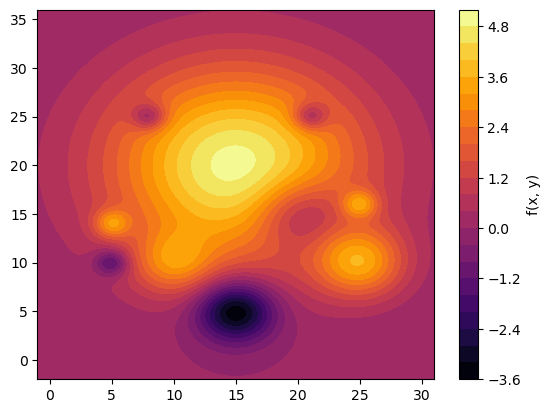

In [105]:
plt.contourf(x, y, f, levels=25, cmap="inferno")
plt.colorbar(label='f(x, y)')

In [113]:
opti = Opti()
x1 = opti.variable()
y1 = opti.variable()
f_ = 5*exp(-0.01*((x1-15)**2 + (y1-20)**2)) - 2*exp(-0.08*((x1-20)**2 + (y1-15)**2)) + 3*exp(-0.08*((x1-25)**2 + (y1-10)**2)) + 2*exp(-0.1*((x1-10)**2 + (y1-10)**2)) - 2*exp(-0.5*((x1-5)**2 + (y1-10)**2)) - 4*exp(-0.1*((x1-15)**2 + (y1-5)**2)) - 2*exp(-0.5*((x1-8)**2 + (y1-25)**2)) - 2*exp(-0.5*((x1-21)**2 + (y1-25)**2)) + 2*exp(-0.5*((x1-25)**2 + (y1-16)**2)) + 2*exp(-0.5*((x1-5)**2 + (y1-14)**2))


initial = [(5,10), (15,5), (8, 25), (20,15), (21,25)]
valores = []


opti.minimize(f_)
opti.solver('sqpmethod')
opti.subject_to(x1>=-1)
opti.subject_to(31>=x1)
opti.subject_to(y1>=-2)
opti.subject_to(36>=y1)

for i in initial:
    xi, yi = i
    opti.set_initial(x1, xi)
    opti.set_initial(y1, yi)
    sol = opti.solve()
    valores.append((sol.value(x1),sol.value(y1)))


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                               2
Number of constraints:                             4
Number of nonzeros in constraint Jacobian:         4
Number of nonzeros in Lagrangian Hessian:          4

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls    info
   0  -1.158498e+00  0.00e+00  2.99e-01  0.00e+00       -  0  - 


####################   qpOASES  --  QP NO.   1   #####################

    Iter

[(4.859331151218192, 9.931844278544578), (15.013596631516766, 4.796742407606725), (7.831470780153225, 25.12037801391141), (20.65649528927943, 14.342103295896178), (21.165641249220595, 25.137662565120806)]


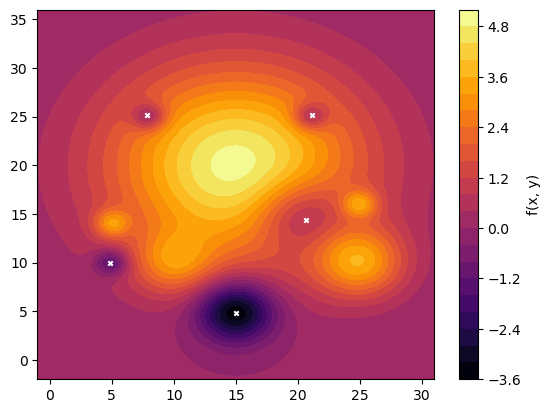

In [114]:
print(valores)
plt.contourf(x, y, f, levels=25, cmap="inferno")
plt.colorbar(label='f(x, y)')
for val in valores:
    plt.scatter(val[0], val[1], marker='x', color='white', s=10)


Punto 3. 

In [120]:
gamma1 = gamma2 = 0.4
A1 = A2 = 50.27
A3 = A4 = 28.27
a1 = 0.233
a2 = 0.242
a3 = a4 = 9.127
g = 9.8

dx1 = - (a1/A1)*np.sqrt(2*g*x1)+(a3/A3)*np.sqrt(2*g*x3)+(gamma1/A1)*u1
dx2 = - (a2/A2)*np.sqrt(2*g*x2)+(a4/A4)*np.sqrt(2*g*x4)+(gamma2/A2)*u2
dx3 = -(a3/A3)*np.sqrt(2*g*x3)+((1-gamma2)/A3)*u2
dx4 = -(a4/A4)*np.sqrt(2*g*x4)+((1-gamma1)/A4)*u1


Q = [[3,0,0,0], [0,3,0,0], [0,0,0.3,0], [0,0,0,0.3]]

NameError: name 'x3' is not defined